In [ ]:
# Without Pixel Loss (MSE)

# 16 x 16 patch GAN
# G dropout = 0.1
# D dropout = 0.4
# lambda_l1 = 0.1
# lambda_gb = 12
# G lr = 0.0003
# D lr = 0.00005

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# pip install torchmetrics torch-fidelity

# 1. MRI - CT DataLoad & Preprocessing

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import transforms, models
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.nn.functional import mse_loss

# Load the .npy files
train_input = np.load('./data(brain-10)/train_input.npy').astype(np.float32)  # Convert to float32
train_output = np.load('./data(brain-10)/train_output.npy').astype(np.float32)  # Convert to float32
val_input = np.load('./data(brain-10)/val_input.npy').astype(np.float32)
val_output = np.load('./data(brain-10)/val_output.npy').astype(np.float32)
test_input = np.load('./data(brain-10)/Test_Patients_InputData/1BA058_input.npy').astype(np.float32)
test_output = np.load('./data(brain-10)/Test_Patients_OutputData/1BA058_output.npy').astype(np.float32)



# Custom transformation function for paired augmentation
class PairedTransform:
    def __init__(self):
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(degrees=10),  # Random rotation within ±10 degrees
        ])
        self.normalize = T.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization

    def __call__(self, mri_image, ct_image):
        seed = random.randint(0, 2**32)  # Fix random seed for synchronized transformations
        torch.manual_seed(seed)
        mri_image = self.transforms(mri_image)
        torch.manual_seed(seed)
        ct_image = self.transforms(ct_image)

        # Normalize both images
        mri_image = self.normalize(mri_image)
        ct_image = self.normalize(ct_image)

        return mri_image, ct_image

# Custom Dataset Class
class MRICTDataset(Dataset):
    def __init__(self, input_data, output_data, transform=None):
        self.input_data = input_data
        self.output_data = output_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        # Load MRI and CT images
        mri_image = torch.tensor(self.input_data[idx][np.newaxis, :, :])  # Single channel
        ct_image = torch.tensor(self.output_data[idx][np.newaxis, :, :])  # Single channel

        if self.transform:
            mri_image, ct_image = self.transform(mri_image, ct_image)  # Paired transformation

        return mri_image, ct_image

# Initialize paired transformations
paired_transform = PairedTransform()

# Create Datasets and DataLoaders
train_dataset = MRICTDataset(train_input, train_output, transform=paired_transform)
val_dataset = MRICTDataset(val_input, val_output, transform=paired_transform)
test_dataset = MRICTDataset(test_input, test_output, transform=paired_transform)

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# 2. Dataset Explanation and metadata Visualization

Training set: 1610 pairs, Size: (1610, 256, 256) (input), (1610, 256, 256) (output)
Validation set: 179 pairs, Size: (179, 256, 256) (input), (179, 256, 256) (output)
Testing set: 197 pairs, Size: (197, 256, 256) (input), (197, 256, 256) (output)


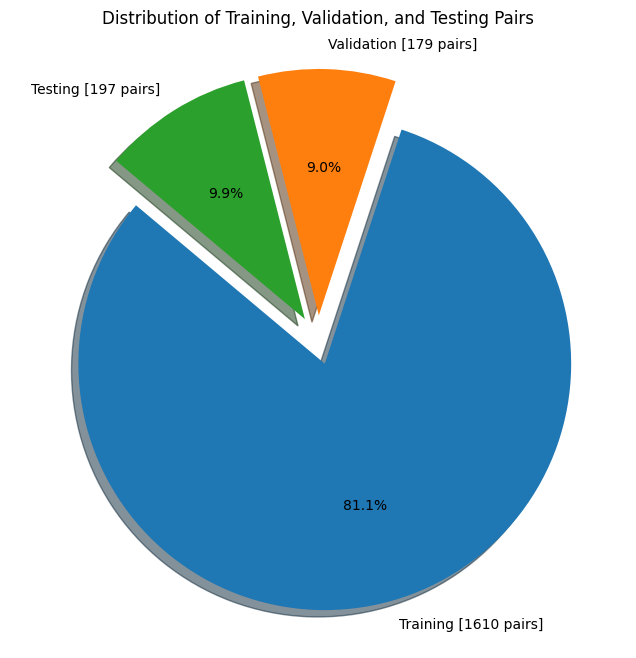

Training set:
 - First MRI image size: (256, 256)
 - First CT image size: (256, 256)
 - All MRI images same size: True
 - All CT images same size: True

Validation set:
 - First MRI image size: (256, 256)
 - First CT image size: (256, 256)
 - All MRI images same size: True
 - All CT images same size: True

Testing set:
 - First MRI image size: (256, 256)
 - First CT image size: (256, 256)
 - All MRI images same size: True
 - All CT images same size: True

MRI shape: torch.Size([30, 1, 256, 256]), CT shape: torch.Size([30, 1, 256, 256])
Using device: cuda


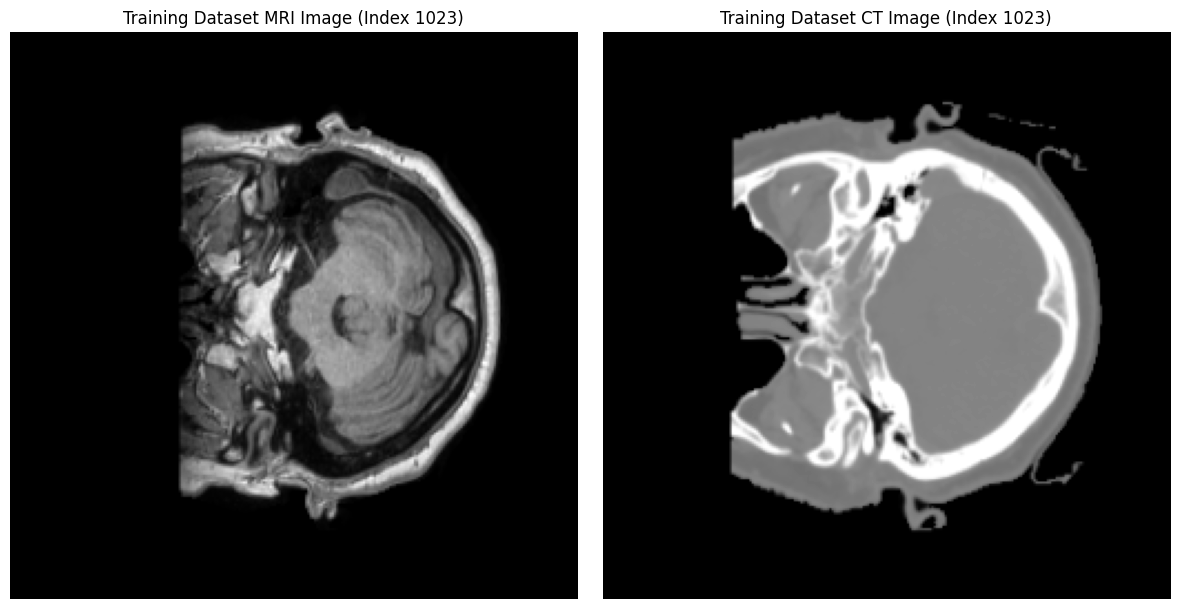

In [5]:
# Print dataset information
print(f'Training set: {len(train_dataset)} pairs, Size: {train_input.shape} (input), {train_output.shape} (output)')
print(f'Validation set: {len(val_dataset)} pairs, Size: {val_input.shape} (input), {val_output.shape} (output)')
print(f'Testing set: {len(test_dataset)} pairs, Size: {test_input.shape} (input), {test_output.shape} (output)')

# Create pie chart at the top showing dataset sizes
labels = ['Training', 'Validation', 'Testing']
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
explode = (0.1, 0.1, 0.1)  # To explode each slice for better visibility

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=[f"{label} [{size} pairs]" for label, size in zip(labels, sizes)],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Distribution of Training, Validation, and Testing Pairs")
plt.show()

# Check sizes and uniformity
def check_image_sizes(dataset, name):
    first_input_size = dataset.input_data[0].shape
    first_output_size = dataset.output_data[0].shape
    all_inputs_same_size = all(img.shape == first_input_size for img in dataset.input_data)
    all_outputs_same_size = all(img.shape == first_output_size for img in dataset.output_data)
    print(f"{name} set:")
    print(f" - First MRI image size: {first_input_size}")
    print(f" - First CT image size: {first_output_size}")
    print(f" - All MRI images same size: {all_inputs_same_size}")
    print(f" - All CT images same size: {all_outputs_same_size}\n")

check_image_sizes(train_dataset, "Training")
check_image_sizes(val_dataset, "Validation")
check_image_sizes(test_dataset, "Testing")

# Verify paired transformations
for mri, ct in train_loader:
    print(f"MRI shape: {mri.shape}, CT shape: {ct.shape}")
    break

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Display a random MRI and CT scan pair from the training dataset
random_idx = random.randint(0, len(train_dataset) - 1)  # Select a random index
mri_image = train_dataset.input_data[random_idx]  # Retrieve MRI image
ct_image = train_dataset.output_data[random_idx]  # Retrieve CT image

# Plot the pair
plt.figure(figsize=(12, 6))  # Adjusted size for stacked layout

# MRI image
plt.subplot(1, 2, 1)  # Side-by-side layout
plt.imshow(mri_image.squeeze(), cmap='gray')
plt.title(f'Training Dataset MRI Image (Index {random_idx})')
plt.axis('off')

# CT image
plt.subplot(1, 2, 2)  # Side-by-side layout
plt.imshow(ct_image.squeeze(), cmap='gray')
plt.title(f'Training Dataset CT Image (Index {random_idx})')
plt.axis('off')

plt.tight_layout()
plt.show()

# 3. Training and Validation Result Visualization

In [6]:
# Initialize dictionaries to store metrics for plotting
training_metrics = {
    "epoch": [],
    "D Loss": [],
    "G Loss": [],
    "GAN Loss": [],
    "D Real Acc": [],
    "D Fake Acc": [],
    "D Avg Acc": []
}

validation_metrics = {
    "epoch": [],
    "SSIM": [],
    "FID": []
}

def log_training_metrics(epoch, d_loss, g_loss, gan_loss, d_real_acc, d_fake_acc, d_avg_acc):
    """Log training metrics after every batch."""
    training_metrics["epoch"].append(epoch)
    training_metrics["D Loss"].append(d_loss)
    training_metrics["G Loss"].append(g_loss)
    training_metrics["GAN Loss"].append(gan_loss)
    training_metrics["D Real Acc"].append(d_real_acc)
    training_metrics["D Fake Acc"].append(d_fake_acc)
    training_metrics["D Avg Acc"].append(d_avg_acc)

def log_validation_metrics(epoch, ssim, fid):
    """Log validation metrics after each epoch."""
    validation_metrics["epoch"].append(epoch)
    validation_metrics["SSIM"].append(ssim)
    validation_metrics["FID"].append(fid)

def plot_metrics(metrics, title, ylabel, keys):
    """Plot line graphs for the given metrics."""
    plt.figure(figsize=(10, 6))
    for key in keys:
        plt.plot(metrics["epoch"], metrics[key], label=key)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

def plot_training_metrics(training_metrics):
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows, 1 column layout

    # Training: D Loss and G Loss
    axes[0].plot(training_metrics["epoch"], training_metrics["D Loss"], label="D Loss")
    axes[0].plot(training_metrics["epoch"], training_metrics["G Loss"], label="G Loss")
    axes[0].set_title("Discriminator and Generator Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid()

    # Discriminator Accuracy
    axes[1].plot(training_metrics["epoch"], training_metrics["D Real Acc"], label="D Real Acc")
    axes[1].plot(training_metrics["epoch"], training_metrics["D Fake Acc"], label="D Fake Acc")
    axes[1].plot(training_metrics["epoch"], training_metrics["D Avg Acc"], label="D Avg Acc")
    axes[1].set_ylim(0, 1)
    axes[1].set_title("Discriminator Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

def plot_validation_metrics(validation_metrics):
    """Plot validation metrics as a set of vertically aligned graphs."""
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))  # 2 rows, 1 column

    epoch = validation_metrics["epoch"]
    fid = validation_metrics["FID"]
    ssim = validation_metrics["SSIM"]

    # 1st Graph: FID
    axes[0].plot(epoch, fid, label="FID", color='blue')
    axes[0].set_title("FID Over Epochs")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("FID")
    axes[0].legend()
    axes[0].grid()

    # 2nd Graph: SSIM
    axes[1].plot(epoch, ssim, label="SSIM", color='red')
    axes[1].set_title("SSIM Over Epochs")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Value (-1 to 1)")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()


# 4. Special Training/Calculation Functions :-
## perceptual_loss || compute_gradient_penalty || Validation

In [7]:
#  perceptual_loss & compute_gradient_penalty & Validation

# Custom perceptual loss function
def perceptual_loss(y_true, y_pred):
    # Convert grayscale to RGB by replicating the single channel to 3 channels
    y_true_rgb = y_true.repeat(1, 3, 1, 1)  # [batch_size, 1, H, W] -> [batch_size, 3, H, W]
    y_pred_rgb = y_pred.repeat(1, 3, 1, 1)

    # Compute the VGG features
    y_true_features = vgg(y_true_rgb)
    y_pred_features = vgg(y_pred_rgb)

    return nn.functional.mse_loss(y_pred_features, y_true_features)

# Function to compute gradient penalty
def compute_gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    # Generate random weight for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    # Interpolate between real and fake images
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)

    # Get discriminator output for interpolated images
    d_interpolates = discriminator(interpolates)

    # Compute gradients of the output with respect to the interpolated images
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute the L2 norm of the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Import necessary modules
import torch.nn.functional as F
from torchvision.models import vgg16
from torchvision.transforms import Resize
from skimage.metrics import structural_similarity as ssim

import torchvision.models as models
import torch.nn.functional as F

# Define VGG-based Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights
        self.vgg = vgg.to(device)

    def forward(self, fake_images, real_images):
        # Convert grayscale (1-channel) to RGB (3-channel)
        if fake_images.shape[1] == 1:
            fake_images = fake_images.repeat(1, 3, 1, 1)  # [Batch, 1, H, W] → [Batch, 3, H, W]
        if real_images.shape[1] == 1:
            real_images = real_images.repeat(1, 3, 1, 1)

        # Extract VGG feature maps
        fake_features = self.vgg(fake_images)
        real_features = self.vgg(real_images)
        loss = F.l1_loss(fake_features, real_features)  # L1 Loss on feature maps
        return loss

# Initialize Perceptual Loss
perceptual_loss_fn = PerceptualLoss()


# Initialize FID metric
fid_metric = FrechetInceptionDistance(normalize=True).to(device)

# Perceptual Loss helper function using VGG16
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, device):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True).features[:16].eval()  # Use layers till relu_2_2
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(device)

    def forward(self, fake, real):
        fake_resized = Resize((224, 224))(fake)  # Resize to 224x224
        real_resized = Resize((224, 224))(real)
        fake_features = self.vgg(fake_resized)
        real_features = self.vgg(real_resized)
        return F.mse_loss(fake_features, real_features)

# Validation function to calculate metrics
def validate(generator, val_loader):
    generator.eval()
    total_ssim = 0.0
    total_fid = 0.0
    total_vgg_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for mri_images, ct_images in val_loader:
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)

            # Generate CT images from MRI
            fake_ct_images = generator(mri_images)

            # Replicate grayscale to RGB
            fake_ct_rgb = fake_ct_images.repeat(1, 3, 1, 1)
            real_ct_rgb = ct_images.repeat(1, 3, 1, 1)

            # Convert images to uint8 for FID
            fake_ct_images_fid = (fake_ct_rgb * 255).clamp(0, 255).byte()
            real_ct_images_fid = (real_ct_rgb * 255).clamp(0, 255).byte()

            # SSIM Calculation
            batch_ssim = 0
            for i in range(fake_ct_images.shape[0]):
                fake = fake_ct_images[i].squeeze().cpu().numpy()
                real = ct_images[i].squeeze().cpu().numpy()
                batch_ssim += ssim(fake, real, data_range=real.max() - real.min())
            total_ssim += batch_ssim / fake_ct_images.shape[0]

            # FID Calculation
            # fid_metric.update(fake_ct_images_fid, real=real_ct_images_fid)
            # batch_fid = fid_metric.compute()
            # total_fid += batch_fid
            fid_metric.update(real_ct_images_fid, real=True)
            fid_metric.update(fake_ct_images_fid, real=False)

            # Perceptual Loss Calculation
            fake_resized = Resize((224, 224))(fake_ct_rgb)
            real_resized = Resize((224, 224))(real_ct_rgb)
            batch_vgg_loss = perceptual_loss_fn(fake_resized, real_resized).item()
            total_vgg_loss += batch_vgg_loss

    # Compute FID after all batches
    avg_fid = fid_metric.compute()

    # Average the metrics over the validation set
    avg_ssim = total_ssim / len(val_loader)
    avg_vgg_loss = total_vgg_loss / len(val_loader)

    return avg_ssim, avg_fid, avg_vgg_loss  # Return 3 values


c:\Users\DELL\anaconda3\envs\gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Hyperparameters

In [8]:
g_lr = 0.0003             # Generator Learning Rate
d_lr = 0.00005            # Discriminator Learning Rate

# Hyperparameter for balancing losses
lambda_l1 = 0.1  # Decreased lambda_l1
lambda_gp = 12  # Weight for gradient penalty

# 5. Trained Model Creation
## Using Generator & Discriminator Training and learning

In [9]:
# Define UNet Generator
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.enc1 = self.encoder_block(1, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        self.enc4 = self.encoder_block(256, 512)
        self.bottleneck = self.encoder_block(512, 1024)

        # Decoder
        self.dec4 = self.decoder_block(1024, 512)
        self.dec3 = self.decoder_block(512 + 512, 256)
        self.dec2 = self.decoder_block(256 + 256, 128)
        self.dec1 = self.decoder_block(128 + 128, 64)
        self.final_upsample = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.14),
            nn.Dropout(p=0.1)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.14),
            nn.Dropout(p=0.1)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        bottleneck = self.bottleneck(enc4)

        dec4 = self.dec4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.dec3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.dec2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.dec1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        out = self.final_upsample(dec1)
        return self.tanh(out)


# PatchGAN Discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=2):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.model(x))


# Loss functions
criterion_GAN = nn.BCELoss()

# Hyperparameters
lambda_gp = 12
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize models
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator(in_channels=1).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.00031, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00006, betas=(0.5, 0.999))

scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=4)
scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=4)

# Training function
def train_pix2pix(generator, discriminator, train_loader, val_loader, num_epochs):
    global best_val_loss, epochs_no_improve
    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        for i, (mri_images, ct_images) in enumerate(train_loader):
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)
            fake_images = generator(mri_images)

            valid = torch.ones_like(discriminator(ct_images), device=device) * 0.90
            fake = torch.zeros_like(discriminator(fake_images.detach()), device=device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_preds = discriminator(ct_images)
            fake_preds = discriminator(fake_images.detach())

            real_loss = criterion_GAN(real_preds, valid)
            fake_loss = criterion_GAN(fake_preds, fake)
            gradient_penalty = compute_gradient_penalty(discriminator, ct_images, fake_images.detach())

            d_loss = (real_loss + fake_loss) / 2 + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

            # Discriminator Accuracy Calculation
            D_real_acc = (real_preds > 0.5).float().mean().item()
            D_fake_acc = (fake_preds < 0.5).float().mean().item()
            D_avg_acc = (D_real_acc + D_fake_acc) / 2

            # Train Generator
            for _ in range(3):
                optimizer_G.zero_grad()
                fake_images = generator(mri_images)
                loss_GAN = criterion_GAN(discriminator(fake_images), valid)

                # Compute Perceptual Loss
                loss_pixel = perceptual_loss_fn(fake_images, ct_images)
                loss_G = loss_GAN + 0.1 * loss_pixel  # Weighted combination

                loss_G.backward()
                optimizer_G.step()

            # Print detailed losses and accuracies
            print(".", end="")
            if (i + 1) % len(train_loader) == 0:  # Prints at the end of each epoch
                print(f"[Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(train_loader)}] "
                      f"[D Loss: {d_loss.item():.6f}] [G Loss: {loss_G.item():.6f}] "
                      f"[GAN Loss: {loss_GAN.item():.6f}] [Perceptual Loss: {loss_pixel.item():.6f}] "
                      f"[D Real Acc: {D_real_acc:.6f}] [D Fake Acc: {D_fake_acc:.6f}] "
                      f"[D Avg Acc: {D_avg_acc:.6f}]")

                # Log training metrics
                # log_training_metrics(epoch + 1, d_loss.item(), loss_G.item(), loss_GAN.item(), loss_pixel.item(), D_real_acc, D_fake_acc, D_avg_acc)
                log_training_metrics(epoch + 1, d_loss.item(), loss_G.item(), loss_GAN.item(), loss_pixel.item(), D_real_acc, D_fake_acc)

        # Validation
        val_ssim, val_fid, val_vgg_loss = validate(generator, val_loader)
        print(f"Validation -> ")
        print(f"[Epoch {epoch + 1}/{num_epochs}] Validation Metrics: SSIM: {val_ssim:.6f}, FID: {val_fid:.6f}, VGG Loss: {val_vgg_loss:.6f}")


        total_val_loss = val_fid.item()  # Convert tensor to scalar # Extract the first value from the tuple
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            epochs_no_improve = 0
            torch.save(generator.state_dict(), 'best_generator.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

        scheduler_G.step(val_fid.item())
        scheduler_D.step(d_loss)

# Train the model
train_pix2pix(generator, discriminator, train_loader, val_loader, num_epochs=50)


# Save final models
torch.save(generator.state_dict(), 'final_generator.pth')
torch.save(discriminator.state_dict(), 'final_discriminator.pth')


......................................................[Epoch 1/50] [Batch 54/54] [D Loss: 0.901692] [G Loss: 0.782918] [GAN Loss: 0.677452] [Perceptual Loss: 1.054662] [D Real Acc: 0.426444] [D Fake Acc: 0.389556] [D Avg Acc: 0.408000]
Validation -> 
[Epoch 1/50] Validation Metrics: SSIM: 0.000141, FID: 462.359924, VGG Loss: 1.086899
......................................................[Epoch 2/50] [Batch 54/54] [D Loss: 0.780512] [G Loss: 0.788247] [GAN Loss: 0.700109] [Perceptual Loss: 0.881380] [D Real Acc: 0.376222] [D Fake Acc: 0.448444] [D Avg Acc: 0.412333]
Validation -> 
[Epoch 2/50] Validation Metrics: SSIM: -0.001607, FID: 435.701935, VGG Loss: 1.012974
......................................................[Epoch 3/50] [Batch 54/54] [D Loss: 0.746764] [G Loss: 0.826142] [GAN Loss: 0.735157] [Perceptual Loss: 0.909855] [D Real Acc: 0.323778] [D Fake Acc: 0.552222] [D Avg Acc: 0.438000]
Validation -> 
[Epoch 3/50] Validation Metrics: SSIM: 0.000796, FID: 433.875000, VGG Loss: 

{'epoch': [], 'SSIM': [], 'FID': []}
{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], 'D Loss': [0.9016923308372498, 0.7805122137069702, 0.746764063835144, 0.9601765871047974, 0.8036541938781738, 0.7964683771133423, 0.7293380498886108, 0.7257051467895508, 0.7172895669937134, 0.7471128106117249, 1.0124022960662842, 0.7177426218986511, 0.8733157515525818, 0.709755003452301, 0.7119454145431519, 0.6788533329963684, 0.63800048828125, 0.6644364595413208, 0.6190731525421143, 0.5677360892295837, 0.570366382598877, 0.4469631314277649, 0.45959144830703735, 0.31142300367355347, 0.28148171305656433, 0.2531180679798126, 0.30449557304382324, 0.2907174229621887], 'G Loss': [0.7829181551933289, 0.7882472276687622, 0.8261420726776123, 0.847240149974823, 0.8636162281036377, 0.8926328420639038, 0.8569194078445435, 0.8546569347381592, 0.8648780584335327, 0.8692743182182312, 0.8667469620704651, 0.8707846403121948, 0.8669398427009583, 0.87340

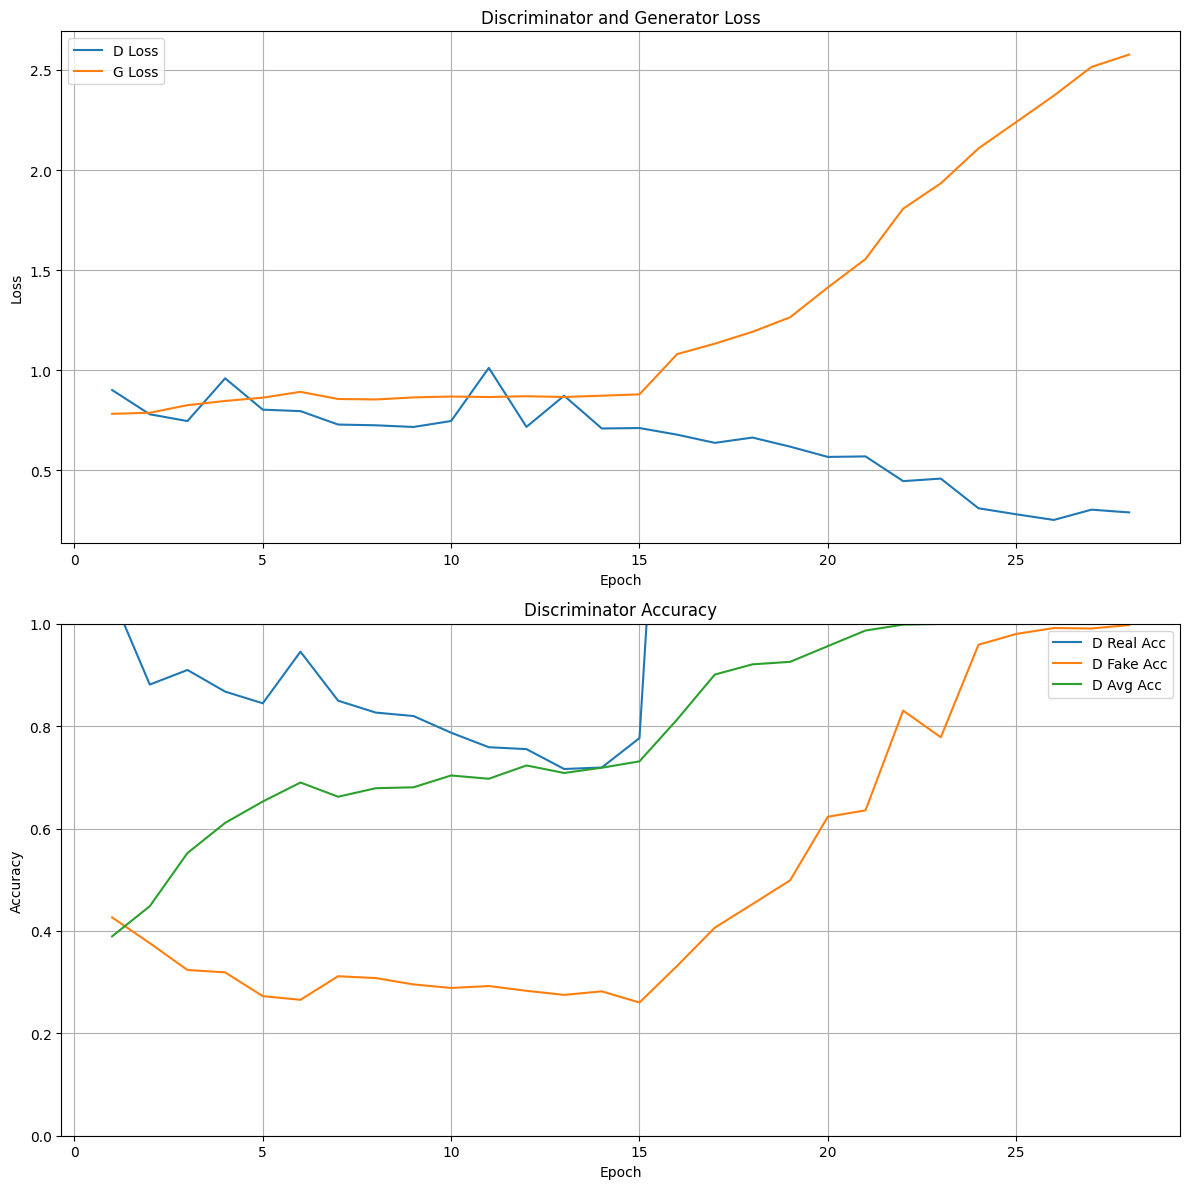

In [10]:
print(validation_metrics)

# Remove MSE from validation metrics
validation_metrics.pop("MSE", None)

# Plot metrics after training
print(training_metrics)
plot_training_metrics(training_metrics)

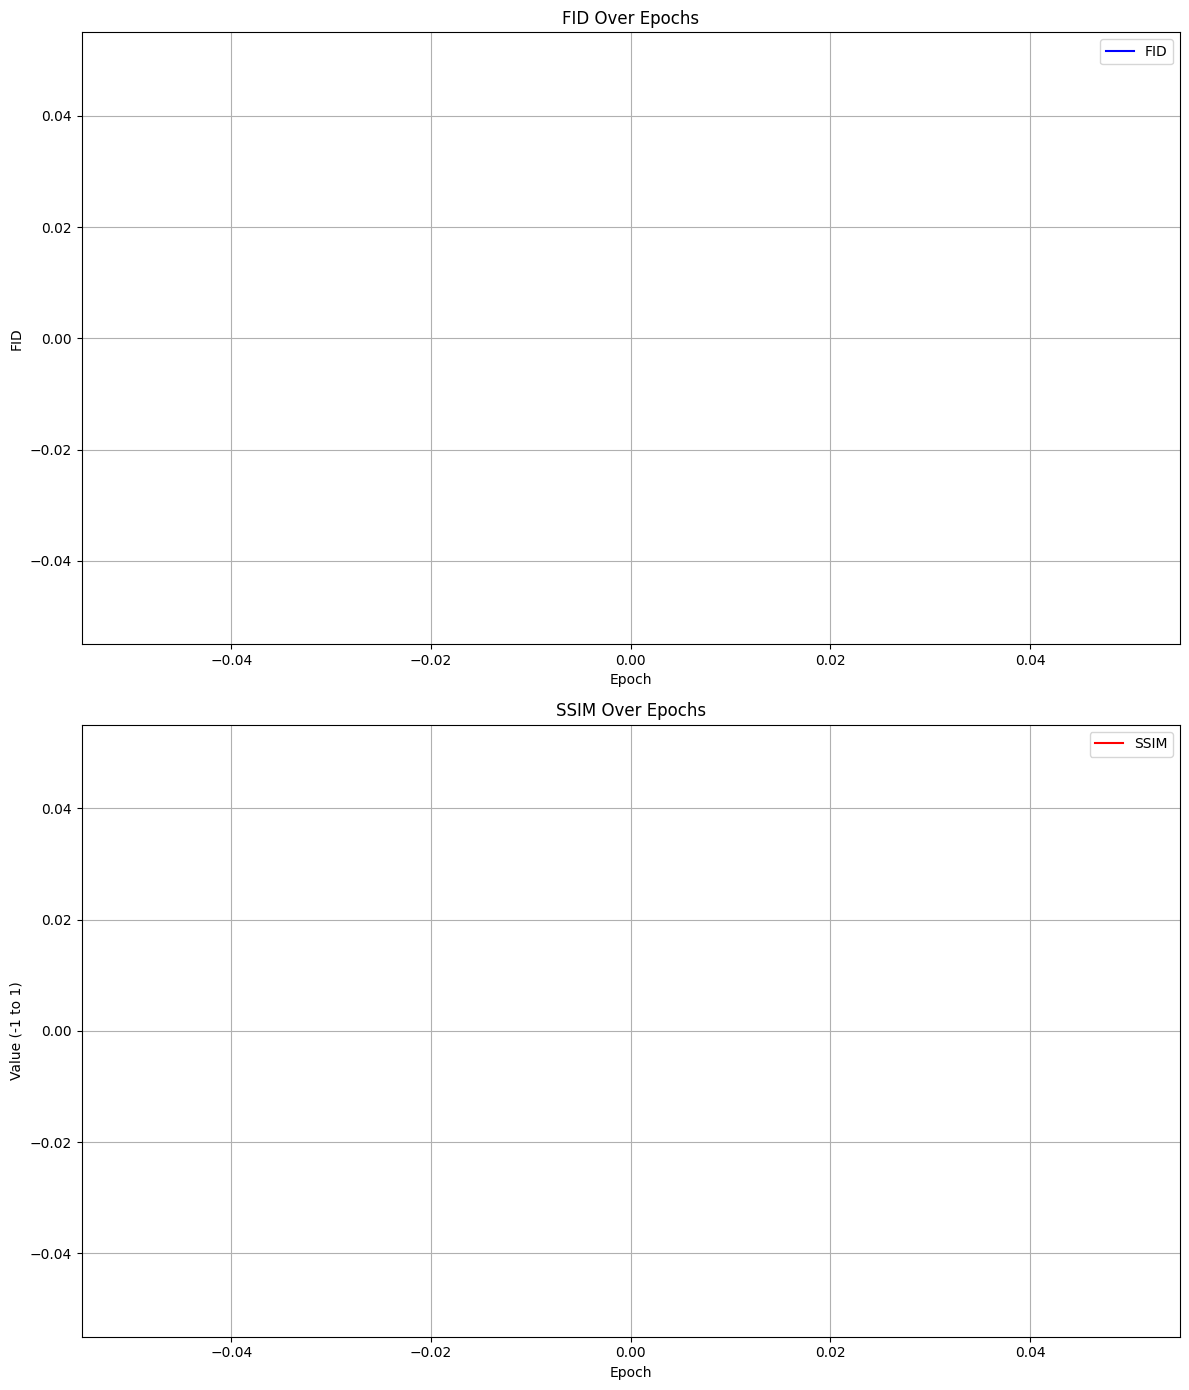

In [11]:
plot_validation_metrics(validation_metrics)

# 6. Random Patient Test Result's

Patient's Test Metric Results -> SSIM: 0.000269, FID: 388.678253, VGG Loss: 1.368983


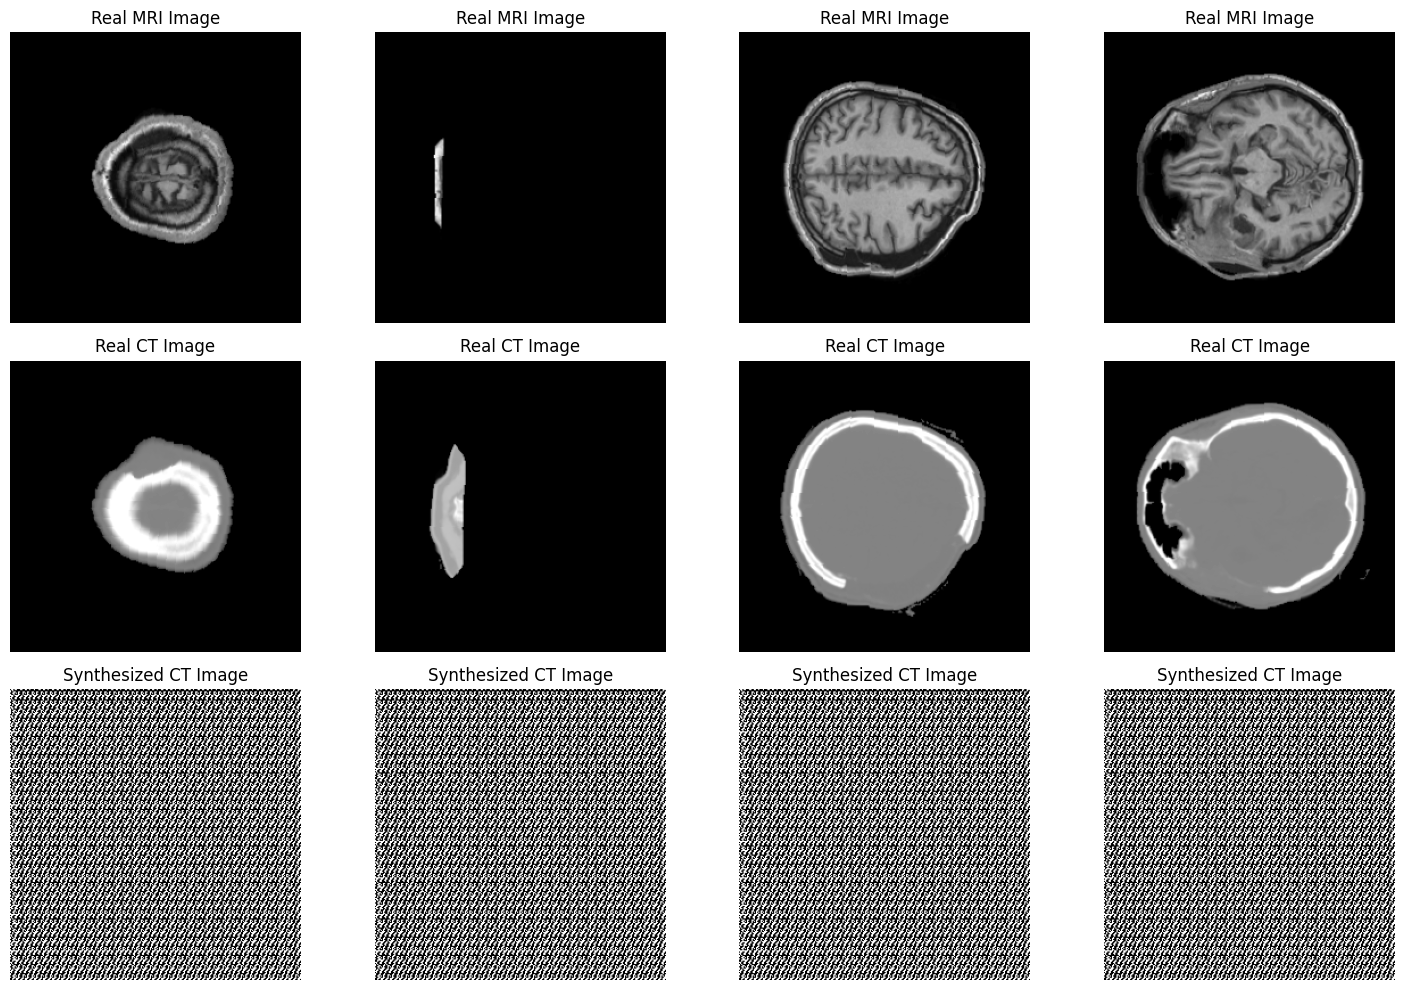

In [12]:
# import torch
# import numpy as np
# import random
# import matplotlib.pyplot as plt

# Load test input and output data
test_input = np.load('./data(brain-10)/Test_Patients_InputData/1BA058_input.npy').astype(np.float32)
test_output = np.load('./data(brain-10)/Test_Patients_OutputData/1BA058_output.npy').astype(np.float32)

# Create test dataset and DataLoader
test_dataset = MRICTDataset(test_input, test_output, transform=paired_transform)
patient_test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Validate on patient-specific test data
test_ssim, test_fid, test_vgg_loss = validate(generator, val_loader)

# Log validation metrics
print("Patient's Test Metric Results -> ", end="")
print(f"SSIM: {test_ssim:.6f}, FID: {test_fid:.6f}, VGG Loss: {test_vgg_loss:.6f}")

# Function to visualize real and synthesized images
def visualize_results(generator, patient_test_loader):
    """Visualize real and synthesized images for single-channel data."""
    generator.eval()
    with torch.no_grad():
        # Select 4 random samples from the test dataset
        sample_indices = random.sample(range(len(patient_test_loader.dataset)), 4)

        plt.figure(figsize=(15, 10))
        for idx, i in enumerate(sample_indices):
            mri_image, ct_image = patient_test_loader.dataset[i]  # Get MRI and CT images
            mri_image = mri_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            generated_image = generator(mri_image).squeeze(0)  # Generate synthetic CT and remove batch dimension

            # Convert images to [0, 1] range for visualization
            mri_image_vis = (mri_image.cpu().squeeze() + 1) / 2  # Normalize to [0,1]
            ct_image_vis = (ct_image.cpu().squeeze() + 1) / 2  # Normalize to [0,1]
            generated_image_vis = (generated_image.cpu().squeeze() + 1) / 2  # Normalize to [0,1]

            # Plot MRI Image
            plt.subplot(3, 4, idx + 1)
            plt.imshow(mri_image_vis, cmap='gray')
            plt.axis('off')
            plt.title('Real MRI Image')

            # Plot CT Image
            plt.subplot(3, 4, idx + 5)
            plt.imshow(ct_image_vis, cmap='gray')
            plt.axis('off')
            plt.title('Real CT Image')

            # Plot Generated CT Image
            plt.subplot(3, 4, idx + 9)
            plt.imshow(generated_image_vis, cmap='gray')
            plt.axis('off')
            plt.title('Synthesized CT Image')

        plt.tight_layout()
        plt.show()

# Call the visualization function
visualize_results(generator, patient_test_loader)
